In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import joblib
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange


from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

from utility import get_imsd, get_imsd_windowed, get_emsd, get_emsd_windowed, fit_hist, MB_2D,\
                    normal_distr, get_trajs, speed_windowed, theta_windowed

show_verb = True
save_verb = True
anim_show_verb = False

In [2]:
rawTrajs = pd.read_parquet("../data/tracking/pre_merge_tracking.parquet")
red_particle_idx = 17
rawTrajs.loc[rawTrajs.particle != red_particle_idx, ["color"]] = "#00007F"
rawTrajs.loc[rawTrajs.particle == red_particle_idx, ["color"]] = "#FF0000"
colors = rawTrajs.loc[rawTrajs.frame == 0, 'color'].values
nDrops = len(rawTrajs.loc[rawTrajs.frame==0])
nFrames = max(rawTrajs.frame) + 1
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")


# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")


# step 10 with a 10 fps video --> 1 s
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

nDrops:50
nFrames:32000 --> 3200.00 s
window of 320.0 s, stride of 10.0 s
number of steps: 288


In [3]:
# Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
smoothTrajs = rawTrajs.copy()
windLen = 30
orderofPoly = 2
for i in range(nDrops):
    smoothTrajs.loc[smoothTrajs.particle == i, "x"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].x.values,
                                                                    windLen, orderofPoly)
    smoothTrajs.loc[smoothTrajs.particle == i, "y"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].y.values,
                                                                    windLen, orderofPoly)        

# Mean Squared Displacement

In [5]:
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered
#x = np.array(imsd[1:].index)
x = np.arange(1., 100.1, .1)

## IMSD

In [6]:
imsd, fit, pw_exp = get_imsd(rawTrajs, pxDimension, fps, maxLagtime, nDrops)
imsd_smooth, fit_smooth, pw_exp_smooth = get_imsd(smoothTrajs, pxDimension, fps, maxLagtime, nDrops)

In [7]:
# residual sum of squares
y = imsd[1:][0]
y_fit = fit[0]
ss_res = np.sum((y - y_fit) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
print(1 - (ss_res / ss_tot))

y = imsd_smooth[1:][0]
y_fit = fit_smooth[0]
ss_res = np.sum((y - y_fit) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
print(1 - (ss_res / ss_tot))

0.9999814141652471
0.9999778393291987


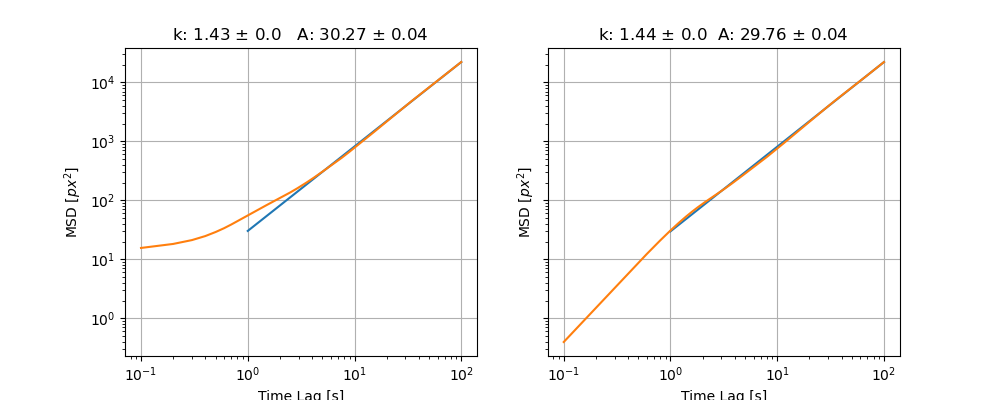

In [8]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 4), sharey=True)
ax.plot(imsd[1:].index, fit[0])
ax.plot(imsd.index, imsd[0])
ax.set_title(f"k: {round(pw_exp[0, 0, 1], 2)} $\pm$ {round(pw_exp[0, 1, 1], 2)}   A: {round(pw_exp[0, 0, 0], 2)} $\pm$ {round(pw_exp[0, 1, 0], 2)} ")
ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = "MSD [$px^2$]")
ax.grid()

ax1.plot(imsd_smooth[1:].index, fit_smooth[0])
ax1.plot(imsd_smooth.index, imsd_smooth[0])
ax1.set_title(f"k: {round(pw_exp_smooth[0, 0, 1], 2)} $\pm$ {round(pw_exp_smooth[0, 1, 1], 2)}  A: {round(pw_exp_smooth[0, 0, 0], 2)} $\pm$ {round(pw_exp_smooth[0, 1, 0], 2)} ")
ax1.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = "MSD [$px^2$]")
ax1.grid()
plt.show()

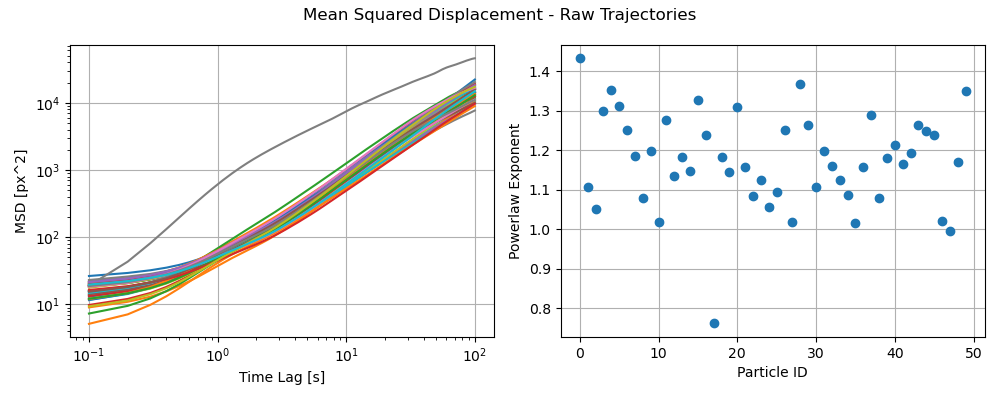

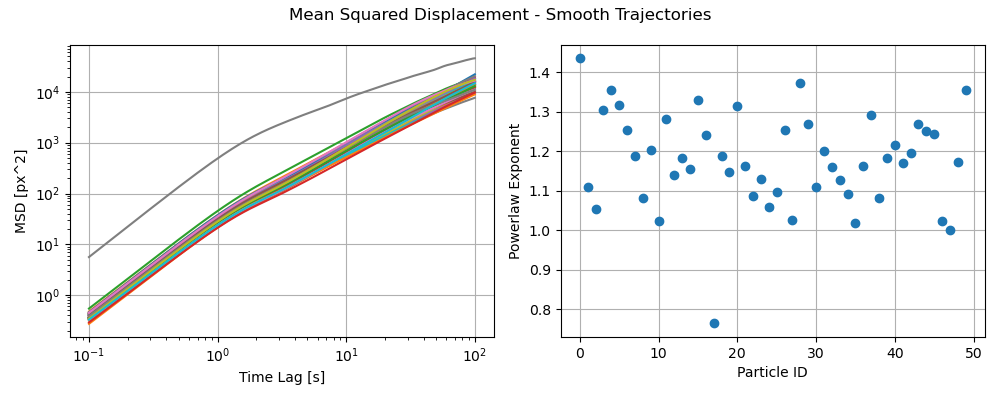

In [9]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.plot(imsd.index, imsd)
ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = "MSD [px^2]")
ax.grid()
ax1.errorbar(np.arange(nDrops), pw_exp[:, 0, 1], yerr=pw_exp[:, 1, 1], fmt = 'o', capsize = 3)
ax1.set(xlabel = "Particle ID", ylabel = "Powerlaw Exponent")
ax1.grid()
plt.suptitle("Mean Squared Displacement - Raw Trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/mean_squared_displacement/IMSD_raw.png", dpi = 500)
if show_verb: 
    plt.show()
else:
    plt.close()

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.plot(imsd_smooth.index, imsd_smooth)
ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = "MSD [px^2]")
ax.grid()
ax1.errorbar(np.arange(nDrops), pw_exp_smooth[:, 0, 1], yerr=pw_exp_smooth[:, 1, 1], fmt = 'o', capsize = 3)
ax1.set(xlabel = "Particle ID", ylabel = "Powerlaw Exponent")
ax1.grid()
plt.suptitle("Mean Squared Displacement - Smooth Trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/mean_squared_displacement/IMSD_smooth.png", dpi = 500)
if show_verb: 
    plt.show()
else:
    plt.close()


## EMSD

In [10]:
MSD_b, MSD_r, fit = get_emsd(imsd, x, red_particle_idx, nDrops)
MSD_b_smooth, MSD_r_smooth, fit_smooth = get_emsd(imsd_smooth, x, red_particle_idx, nDrops)

Raw trajs - Blue Particles: 1.179 ± 0.002, Red Particle: 0.762 ± 0.002


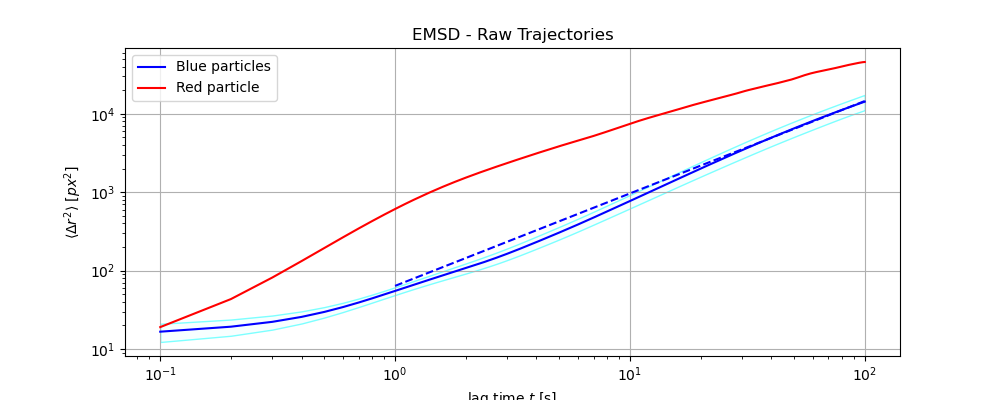

Smooth trajs - Blue Particles: 1.183 ± 0.002, Red Particle: 0.765 ± 0.002


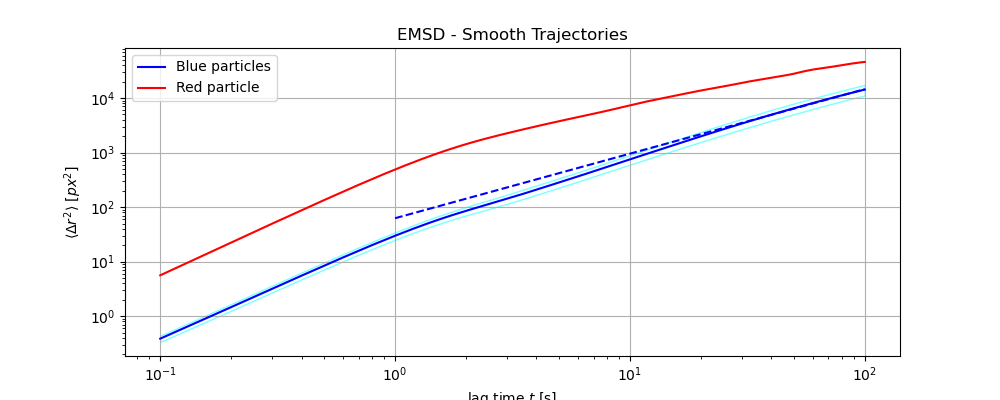

In [11]:
a = [round(fit["pw_exp_b"][0, 1], 3), round(fit["pw_exp_b"][1, 1], 3)]
b = [round(fit["pw_exp_r"][0, 1], 3), round(fit["pw_exp_r"][1, 1], 3)]
print(f"Raw trajs - Blue Particles: {a[0]} ± {a[1]}, Red Particle: {b[0]} ± {b[1]}")
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(imsd.index, MSD_b[0], 'b-', label = "Blue particles") 
ax.plot(imsd[1:].index, fit["fit_b"], 'b--')
ax.fill_between(imsd.index, MSD_b[0] - MSD_b[1], MSD_b[0] + MSD_b[1], alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax.plot(imsd.index, MSD_r, 'r-', label = "Red particle")
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',   
        xlabel = 'lag time $t$ [s]', title = "EMSD - Raw Trajectories")
ax.legend()
ax.grid()
if save_verb: plt.savefig("../results/mean_squared_displacement/EMSD_raw.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()
    

a = [round(fit_smooth["pw_exp_b"][0, 1], 3), round(fit_smooth["pw_exp_b"][1, 1], 3)]
b = [round(fit_smooth["pw_exp_r"][0, 1], 3), round(fit_smooth["pw_exp_r"][1, 1], 3)]
print(f"Smooth trajs - Blue Particles: {a[0]} ± {a[1]}, Red Particle: {b[0]} ± {b[1]}")
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(imsd_smooth.index, MSD_b_smooth[0], 'b-', label = "Blue particles") 
ax.plot(imsd_smooth[1:].index, fit_smooth["fit_b"], 'b--')
ax.fill_between(imsd_smooth.index, MSD_b_smooth[0] - MSD_b_smooth[1], MSD_b_smooth[0] + MSD_b_smooth[1], 
                    alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax.plot(imsd_smooth.index, MSD_r_smooth, 'r-', label = "Red particle")
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',   
         xlabel = 'lag time $t$ [s]', title = "EMSD - Smooth Trajectories")
ax.legend()
ax.grid()
if save_verb: plt.savefig("../results/mean_squared_displacement/EMSD_smooth.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()

## Windowed Analysis

### IMSD 

In [12]:
if 1:
    MSD_wind, fit_wind, pw_exp_wind = get_imsd_windowed(nSteps, startFrames, endFrames, rawTrajs, pxDimension, fps, maxLagtime, nDrops)

    MSD_wind_smooth, fit_wind_smooth, pw_exp_wind_smooth = get_imsd_windowed(nSteps, startFrames, endFrames, smoothTrajs, 
                                                                            pxDimension, fps, maxLagtime, nDrops)
    if 0:
        for k in range(nDrops):
            MSD_wind[k].columns = [str(i) for i in range(nDrops)]
            MSD_wind[k].to_parquet(f"../data/analysis/MSD/raw/MSD_wind_raw{k}.parquet")
            MSD_wind_smooth[k].columns = [str(i) for i in range(nDrops)]
            MSD_wind_smooth[k].to_parquet(f"../data/analysis/MSD/smooth/MSD_wind_smooth{k}.parquet")
else:
    MSD_wind = []
    MSD_wind_smooth = []
    for k in range(nDrops):
        temp = pd.read_parquet(f"../data/analysis/MSD/raw/MSD_wind_raw{k}.parquet")
        temp.columns = [i for i in range(nDrops)]
        MSD_wind.append(temp)
        temp = pd.read_parquet(f"../data/analysis/MSD/smooth/MSD_wind_smooth{k}.parquet") 
        temp.columns = [i for i in range(nDrops)]
        MSD_wind_smooth.append(temp)

100%|██████████| 288/288 [05:00<00:00,  1.04s/it]


In [13]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_wind[step].iloc[:, i]))
    title.set_text(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    graph1.set_ydata(pw_exp_wind[step, :, 0, 1])
    return graphic_data, graph1,


title = ax.set_title(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]))[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.5, 10**5))
ax.grid()

ax1.set(xlabel = "Particle ID", ylabel = r"$\beta$", ylim = (0, 2))
graph1, = ax1.plot(np.arange(nDrops), pw_exp_wind[0, :, 0, 1], '.', markersize = 10)
ax1.axvline(x = red_particle_idx, color = 'r', linestyle = '--')

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/IMSD_wind_raw.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:09:05 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:09:05 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/IMSD_wind_raw.mp4


In [14]:
# version 2
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_wind[step].iloc[:, i]))
        graphic_data2[i].set_data(startFrames[:step]/10, pw_exp_wind[:step, i, 0, 1])
    title.set_text(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    ax1.set_xlim(0, startFrames[step]/10 + 0.0001)
    return graphic_data, graphic_data2,


title = ax.set_title(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]), color=colors[i], alpha = 1)[0])
    else:
        graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim = (0.5, 10**5))
ax.grid()

graphic_data2 = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data2.append(ax1.plot(startFrames[0]/10, pw_exp_wind[0, i, 0, 1], color=colors[i], alpha = 1)[0])
    else:
        graphic_data2.append(ax1.plot(startFrames[0]/10, pw_exp_wind[0, i, 0, 1], color=colors[i], alpha = 0.3)[0])
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
ax1.grid()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/IMSD_wind_raw_v2.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:09:36 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:09:36 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/IMSD_wind_raw_v2.mp4


In [15]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_wind_smooth[step].iloc[:, i]))
    title.set_text(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    graph1.set_ydata(pw_exp_wind_smooth[step, :, 0, 1])
    return graphic_data, graph1,


title = ax.set_title(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    graphic_data.append(ax.plot(MSD_wind_smooth[i].index, np.array(MSD_wind_smooth[0].iloc[:, i]))[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.05, 10**5))
ax.grid()

ax1.set(xlabel = "Particle ID", ylabel = r"$\beta$", ylim = (0, 2))
graph1, = ax1.plot(np.arange(nDrops), pw_exp_wind_smooth[0, :, 0, 1], '.', markersize = 10)
ax1.axvline(x = red_particle_idx, color = 'r', linestyle = '--')

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/IMSD_wind_smooth.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:10:14 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:10:14 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/IMSD_wind_smooth.mp4


In [16]:
# version 2
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_wind_smooth[step].iloc[:, i]))
        graphic_data2[i].set_data(startFrames[:step]/10, pw_exp_wind_smooth[:step, i, 0, 1])
    title.set_text(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    ax1.set_xlim(0, startFrames[step]/10 + 0.0001)
    return graphic_data, graphic_data2,


title = ax.set_title(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data.append(ax.plot(MSD_wind_smooth[i].index, np.array(MSD_wind_smooth[0].iloc[:, i]), color=colors[i], alpha = 1)[0])
    else:
        graphic_data.append(ax.plot(MSD_wind_smooth[i].index, np.array(MSD_wind_smooth[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim = (0.1, 10**5))
ax.grid()

graphic_data2 = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data2.append(ax1.plot(startFrames[0]/10, pw_exp_wind_smooth[0, i, 0, 1], color=colors[i], alpha = 1)[0])
    else:
        graphic_data2.append(ax1.plot(startFrames[0]/10, pw_exp_wind_smooth[0, i, 0, 1], color=colors[i], alpha = 0.3)[0])
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
ax1.grid()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/IMSD_wind_smooth_v2.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:10:44 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:10:44 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/IMSD_wind_smooth_v2.mp4


### EMSD 

In [20]:
EMSD_wind_b, EMSD_wind_r, fit_dict = get_emsd_windowed(MSD_wind, x, nDrops, red_particle_idx, nSteps, maxLagtime)
EMSD_wind_b_smooth, EMSD_wind_r_smooth, fit_dict_smooth = get_emsd_windowed(MSD_wind_smooth, x, nDrops, red_particle_idx, nSteps, maxLagtime)

100%|██████████| 288/288 [00:02<00:00, 137.73it/s]


In [18]:
fit_dict.keys()

dict_keys(['fit_wind_b', 'pw_exp_wind_b', 'fit_wind_r', 'pw_exp_wind_r'])

In [24]:
Y1_msd = EMSD_wind_b[0] - EMSD_wind_b[1]
Y2_msd = EMSD_wind_b[0] + EMSD_wind_b[1]

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    # update title
    title.set_text(f"Mean Squared Displacement - Raw Trajectories - window {startFrames[step]/10} - {endFrames[step]/10} seconds")
    # update MSD
    graphic_data[0].set_ydata(EMSD_wind_b[0][step])
    graphic_data[1].set_ydata(EMSD_wind_r[step])
    # update fill between
    path = fill_graph.get_paths()[0]
    verts = path.vertices
    verts[1:1000+1, 1] = Y1_msd[step, :]
    verts[1000+2:-1, 1] = Y2_msd[step, :][::-1]
    # update powerlaw exponents
    line.set_data(startFrames[:step]/10, fit_dict["pw_exp_wind_b"][:step, 0, 1])
    line1.set_data(startFrames[:step]/10, fit_dict["pw_exp_wind_r"][:step, 0, 1]) 
    line2.set_data(startFrames[:step]/10, np.ones(step)) 
    ax1.set_xlim(0, (startFrames[step]+10)/10)
    return graphic_data, fill_graph, line, line1, 


title = ax.set_title(f"Mean Squared Displacement - Raw Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
graphic_data = []
graphic_data.append(ax.plot(np.arange(0.1, 100.1, 0.1), EMSD_wind_b[0][0], 'b-', alpha=0.5, label = "Blue particles")[0] )
graphic_data.append(ax.plot(np.arange(0.1, 100.1, 0.1), EMSD_wind_r[0], 'r-' , label = "Red particle")[0] )
fill_graph = ax.fill_between(np.arange(0.1, 100.1, 0.1), Y1_msd[0], Y2_msd[0], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.5, 10**5))
ax.legend()
ax.grid()

line, = ax1.plot(startFrames[0]/10, fit_dict["pw_exp_wind_b"][0, 0, 1], 'b-', alpha = 0.5, label = 'Blue particles')
line1, = ax1.plot(startFrames[0]/10, fit_dict["pw_exp_wind_r"][0, 0, 1], 'r-', alpha = 0.5, label = 'Red particle')
line2, = ax1.plot(startFrames[0]/10, 1, 'k-')
ax1.legend()
ax1.grid()
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/EMSD_wind_raw.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:24:40 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:24:40 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/EMSD_wind_raw.mp4


In [25]:
Y1_msd_smooth = EMSD_wind_b_smooth[0] - EMSD_wind_b_smooth[1]
Y2_msd_smooth = EMSD_wind_b_smooth[0] + EMSD_wind_b_smooth[1]

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    # update title
    title.set_text(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    # update MSD
    graphic_data[0].set_ydata(EMSD_wind_b_smooth[0][step])
    graphic_data[1].set_ydata(EMSD_wind_r_smooth[step])
    # update fill between
    path = fill_graph.get_paths()[0]
    verts = path.vertices
    verts[1:1000+1, 1] = Y1_msd_smooth[step, :]
    verts[1000+2:-1, 1] = Y2_msd_smooth[step, :][::-1]
    # update powerlaw exponents
    line.set_data(startFrames[:step]/10, fit_dict_smooth["pw_exp_wind_b"][:step, 0, 1])
    line1.set_data(startFrames[:step]/10, fit_dict_smooth["pw_exp_wind_r"][:step, 0, 1])
    line2.set_data(startFrames[:step]/10, np.ones(step)) 
    ax1.set_xlim(0, (startFrames[step]+10)/10)
    return graphic_data, fill_graph, line, line1, 


title = ax.set_title(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
graphic_data.append(ax.plot(np.arange(0.1, 100.1, 0.1), EMSD_wind_b_smooth[0][0], 'b-', alpha=0.5, label = "Blue particles")[0] )
graphic_data.append(ax.plot(np.arange(0.1, 100.1, 0.1), EMSD_wind_r_smooth[0], 'r-' , label = "Red particle")[0] )
fill_graph = ax.fill_between(np.arange(0.1, 100.1, 0.1), Y1_msd_smooth[0], Y2_msd_smooth[0], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.1, 10**5))
ax.legend()
ax.grid()

line, = ax1.plot(startFrames[0]/10, fit_dict_smooth["pw_exp_wind_b"][0, 0, 1], 'b-', alpha = 0.5, label = 'Blue particles')
line1, = ax1.plot(startFrames[0]/10, fit_dict_smooth["pw_exp_wind_r"][0, 0, 1], 'r-', alpha = 0.5, label = 'Red particles')
line2, = ax1.plot(startFrames[0]/10, 1, 'k-')
ax1.legend()
ax1.grid()
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/windowed_analysis/EMSD_wind_smooth.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

14:26:02 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:26:02 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/mean_squared_displacement/windowed_analysis/EMSD_wind_smooth.mp4


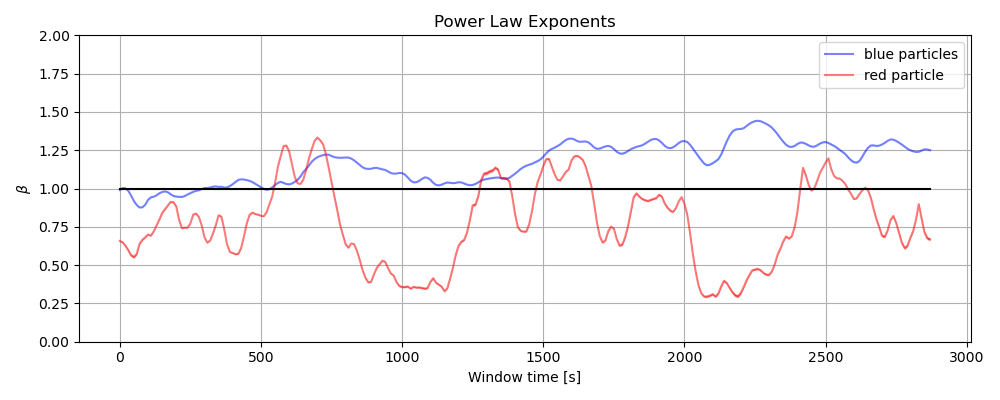

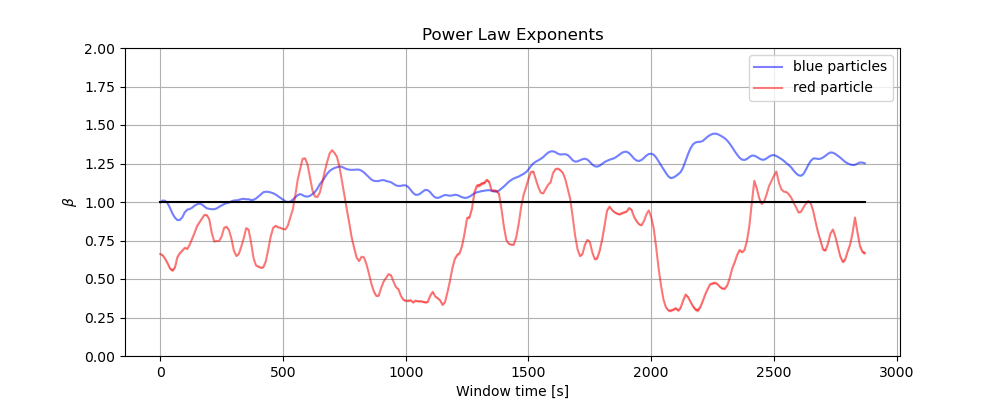

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title(f"Power Law Exponents")
ax.plot(startFrames/10, fit_dict["pw_exp_wind_b"][:, 0, 1], 'b-', alpha = 0.5, label = 'blue particles')
ax.fill_between(startFrames/10, fit_dict["pw_exp_wind_b"][:, 0, 1] - fit_dict["pw_exp_wind_b"][:, 1, 1],     
                    fit_dict["pw_exp_wind_b"][:, 0, 1] + fit_dict["pw_exp_wind_b"][:, 1, 1],
                    alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.plot(startFrames/10, fit_dict["pw_exp_wind_r"][:, 0, 1], 'r-', alpha = 0.5, label = 'red particle ')
ax.fill_between(startFrames/10, fit_dict["pw_exp_wind_r"][:, 0, 1] - fit_dict["pw_exp_wind_r"][:, 1, 1],
                    fit_dict["pw_exp_wind_r"][:, 0, 1] + fit_dict["pw_exp_wind_r"][:, 1, 1],
                    alpha=0.5, edgecolor='#F0FFFF', facecolor='#FF0000')
ax.plot(startFrames/10, np.ones(nSteps), 'k-')
ax.legend()
ax.grid()
ax.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
plt.tight_layout()
if save_verb: plt.savefig('../results/mean_squared_displacement/EMSD_beta_raw.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title(f"Power Law Exponents")
ax.plot(startFrames/10, fit_dict_smooth["pw_exp_wind_b"][:, 0, 1], 'b-', alpha = 0.5, label = 'blue particles')
ax.fill_between(startFrames/10,  fit_dict_smooth["pw_exp_wind_b"][:, 0, 1] -  fit_dict_smooth["pw_exp_wind_b"][:, 1, 1],     
                     fit_dict_smooth["pw_exp_wind_b"][:, 0, 1] +  fit_dict_smooth["pw_exp_wind_b"][:, 1, 1],
                    alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.plot(startFrames/10, fit_dict_smooth["pw_exp_wind_r"][:, 0, 1], 'r-', alpha = 0.5, label = 'red particle ')
ax.fill_between(startFrames/10,  fit_dict_smooth["pw_exp_wind_r"][:, 0, 1] -  fit_dict_smooth["pw_exp_wind_r"][:, 1, 1],
                        fit_dict_smooth["pw_exp_wind_r"][:, 0, 1] +  fit_dict_smooth["pw_exp_wind_r"][:, 1, 1],
                        alpha=0.5, edgecolor='#F0FFFF', facecolor='#FF0000')
ax.plot(startFrames/10, np.ones(nSteps), 'k-')
ax.legend()
ax.grid()
ax.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
if save_verb: plt.savefig('../results/mean_squared_displacement/EMSD_beta_smooth.png', dpi = 500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# Speed Distribution

$$ \huge p(v) = \frac{v}{\sigma^2} e^{-\frac{v^2}{2\sigma^2}} $$

In [ ]:
blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs) 

bin_borders = np.arange(0, 100, .2)
bin_centers = np.arange(0, 100, .2)[:-1] + .2 / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

v_blue = ys.speed_ensemble(blueTrajs, step = 10)
v_red = ys.speed_ensemble(redTraj, step = 10)
T_blue, T_blue_std = fit_hist(v_blue, bin_borders, MB_2D, [1.])
T_red, T_red_std = fit_hist(v_red, bin_borders, MB_2D, [1.])
print(f"Blue fit sigma: {T_blue[0]}", f"{T_blue_std[0]}")
print(f"Red fit sigma: {T_red[0]}", f"{T_red_std[0]}")


v_blue_smooth = ys.speed_ensemble(blueTrajs_smooth, step = 10)
v_red_smooth = ys.speed_ensemble(redTraj_smooth, step = 10)
T_blue_smooth, T_blue_smooth_std = fit_hist(v_blue_smooth, bin_borders, MB_2D, [1.])
T_red_smooth, T_red_smooth_std = fit_hist(v_red_smooth, bin_borders, MB_2D, [1.])
print(f"Blue fit sigma: {T_blue_smooth[0]}", f"{T_blue_smooth_std[0]}")
print(f"Red fit sigma: {T_red_smooth[0]}", f"{T_red_smooth_std[0]}")

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 5))
ax.hist(v_blue, bins = bin_borders, **default_kwargs_blue)
ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_blue), 'k-', label = f"$T = {T_blue[0]:.2f} \pm {T_blue_std[0]:.2f}$")
ax.set(title = "Blue particles velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()

ax1.hist(v_red, bins = bin_borders, **default_kwargs_red)
ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_red), 'k-', label = f"$T = {T_red[0]:.2f} \pm {T_red_std[0]:.2f}$")
ax1.set(title = "Red particle velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()

plt.suptitle("Raw trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/speed_distribution/speed_raw.png", bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 5))
ax.hist(v_blue_smooth, bins = bin_borders, **default_kwargs_blue)
ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_blue_smooth), 'k-', 
            label = f"$T = {T_blue_smooth[0]:.2f} \pm {T_blue_smooth_std[0]:.2f}$")
ax.set(title = "Blue particles velocity distribution", xlabel = f"speed [{units}]", 
            ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()

ax1.hist(v_red_smooth, bins = bin_borders, **default_kwargs_red)
ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_red_smooth), 'k-', 
            label = f"$T = {T_red_smooth[0]:.2f} \pm {T_red_smooth_std[0]:.2f}$")
ax1.set(title = "Red particle velocity distribution", xlabel = f"speed [{units}]",
            ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()
plt.suptitle("Smooth trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/speed_distribution/speed_smooth.png", bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

## Windowed Analysis

In [ ]:
v_blue_wind, v_red_wind = speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, rawTrajs)
blue_fit_wind = np.ones((nSteps, 2))
red_fit_wind = np.ones((nSteps, 2))

for k in range(nSteps):
    blue_fit_wind[k, 0], blue_fit_wind[k, 1] = fit_hist(v_blue_wind[k], bin_borders, MB_2D, [1.])
    red_fit_wind[k, 0], red_fit_wind[k, 1] = fit_hist(v_red_wind[k], bin_borders, MB_2D, [1.])


v_blue_wind_smooth, v_red_wind_smooth = speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, smoothTrajs)
blue_fit_wind_smooth = np.ones((nSteps, 2))
red_fit_wind_smooth = np.ones((nSteps, 2))

for k in range(nSteps):
    blue_fit_wind_smooth[k, 0], blue_fit_wind_smooth[k, 1] = fit_hist(v_blue_wind_smooth[k], bin_borders, MB_2D, [1.])
    red_fit_wind_smooth[k, 0], red_fit_wind_smooth[k, 1] = fit_hist(v_red_wind_smooth[k], bin_borders, MB_2D, [1.])

### PLOT

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        # update titles
        title.set_text(f"Raw Trajectories - window {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        #title2.set_text(f"Red particle velocity pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")

        # update histogram 1
        n, _ = np.histogram(v_blue_wind[frame], bin_borders, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        
        line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_wind[frame, 0]))

        # update histogram 2
        n2, _ = np.histogram(v_red_wind[frame], bin_borders, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
            
        line1.set_ydata(MB_2D(x_interval_for_fit, red_fit_wind[frame, 0]))

        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(v_blue_wind[0], bin_borders, **default_kwargs_blue, label="blue particles")
title = ax.set_title(f"Raw Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind[0, 0]), label='fit')
ax.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()

_, _, bar_container2 = ax1.hist(v_red_wind[0], bin_borders,  **default_kwargs_red, label="red particle")
#title2 = ax1.set_title(f"Red particle velocity pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
line1, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_wind[0, 0]), label='fit')
ax1.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
if save_verb: ani.save('../results/speed_distribution/speed_raw_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        # update titles
        title.set_text(f"Smooth Trajectories - window {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        #title2.set_text(f"Red particle velocity pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")

        # update histogram 1
        n, _ = np.histogram(v_blue_wind_smooth[frame], bin_borders, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        
        line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_wind_smooth[frame, 0]))

        # update histogram 2
        n2, _ = np.histogram(v_red_wind_smooth[frame], bin_borders, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
            
        line1.set_ydata(MB_2D(x_interval_for_fit, red_fit_wind_smooth[frame, 0]))

        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(v_blue_wind_smooth[0], bin_borders, **default_kwargs_blue, label="blue particles")
title = ax.set_title(f"Raw Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind_smooth[0, 0]), label='fit')
ax.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()

_, _, bar_container2 = ax1.hist(v_red_wind_smooth[0], bin_borders,  **default_kwargs_red, label="red particle")
#title2 = ax1.set_title(f"Red particle velocity pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
line1, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_wind_smooth[0, 0]), label='fit')
ax1.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
if save_verb: ani.save('../results/speed_distribution/speed_smooth_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 4), sharex=True)
ax.errorbar(startFrames/10, blue_fit_wind[:, 0], yerr = blue_fit_wind[:, 1], fmt = 'b', label="blue particles")
ax.set(ylabel = "T [??]", ylim = (1, 5), title = "Effective Temperature - Raw Trajectories")
ax.legend()
ax.grid()

ax1.errorbar(startFrames/10, red_fit_wind[:, 0], yerr = red_fit_wind[:, 1], fmt = 'r', label="red particles")
ax1.set(xlabel ="time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/speed_distribution/T_eff_raw.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

    
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 4), sharex=True)
ax.errorbar(startFrames/10, blue_fit_wind_smooth[:, 0], yerr = blue_fit_wind_smooth[:, 1], fmt = 'b', label="blue particles")
ax.set(ylabel = "T [??]", ylim = (1, 5), title = "Effective Temperature - Smooth Trajectories")
ax.legend()
ax.grid()

ax1.errorbar(startFrames/10, red_fit_wind_smooth[:, 0], yerr = red_fit_wind_smooth[:, 1], fmt = 'r', label="red particles")
ax1.set(xlabel = "time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/speed_distribution/T_eff_smooth.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# Turning Angles Distribution

$$ \huge f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

In [4]:
blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)

bin_borders_turn = np.arange(-np.pi, np.pi + 0.0001, np.pi/50)
bin_centers_turn = bin_borders_turn[:-1] + np.diff(bin_borders_turn) / 2
x_interval_for_fit_turn = np.linspace(bin_borders_turn[0], bin_borders_turn[-1], 10000)

theta_blue = ys.turning_angles_ensemble(blueTrajs, centered = True)
theta_red = ys.turning_angles_ensemble(redTraj, centered = True)
# normal distribution fit
T_blue_rot, T_blue_rot_std = fit_hist(theta_blue, bin_borders_turn, normal_distr, [1., 0.])
T_red_rot, T_red_rot_std = fit_hist(theta_red, bin_borders_turn, normal_distr, [1., 0.])
print(f"Blue fit sigma: {T_blue_rot[0]}", f"{T_blue_rot_std[0]}")
print(f"Blue fit mu: {T_blue_rot[1]}", f"{T_blue_rot_std[1]}")
print(f"Red fit sigma: {T_red_rot[0]}", f"{T_red_rot_std[0]}")
print(f"Red fit mu: {T_red_rot[1]}", f"{T_red_rot_std[1]}")


theta_blue_smooth = ys.turning_angles_ensemble(blueTrajs_smooth, centered = True)
theta_red_smooth = ys.turning_angles_ensemble(redTraj_smooth, centered = True)
# normal distribution fit
T_blue_rot_smooth, T_blue_rot_smooth_std = fit_hist(theta_blue_smooth, bin_borders_turn, normal_distr, [1., 0.])
T_red_rot_smooth, T_red_rot_smooth_std = fit_hist(theta_red_smooth, bin_borders_turn, normal_distr, [1., 0.])
print(f"Blue fit sigma: {T_blue_rot_smooth[0]}", f"{T_blue_rot_smooth_std[0]}")
print(f"Blue fit mean: {T_blue_rot_smooth[1]}", f"{T_blue_rot_smooth_std[1]}")
print(f"Red fit sigma: {T_red_rot_smooth[0]}", f"{T_red_rot_smooth_std[0]}")
print(f"Red fit mean: {T_red_rot_smooth[1]}", f"{T_red_rot_smooth_std[1]}")

Blue fit sigma: 2.917682835740027 0.30949859447841155
Blue fit mu: -0.0007054159678248849 0.4540618048966584
Red fit sigma: 2.4384780096960923 0.15247337370262667
Red fit mu: 0.017968089879776165 0.19547887167646438
Blue fit sigma: 0.4532020875829226 0.012243069144373108
Blue fit mean: 0.00038165827270340245 0.014994576804522203
Red fit sigma: 0.19514856444555856 0.004919473860240537
Red fit mean: 0.0040682468147739065 0.00602510062559018


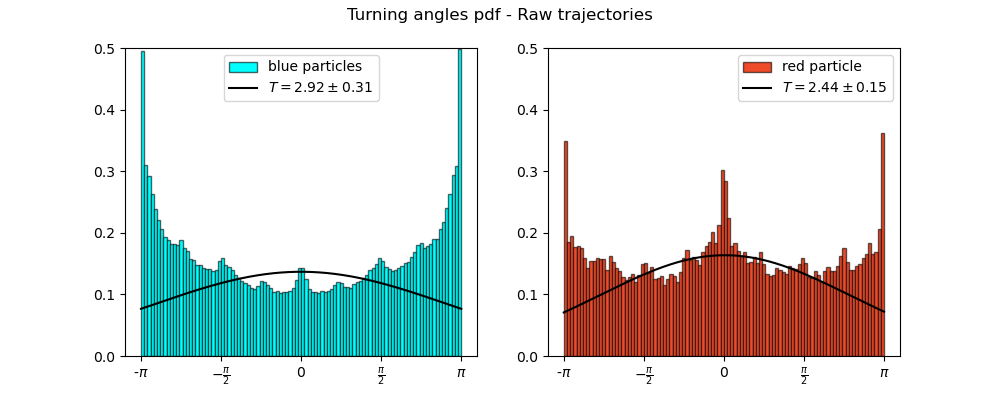

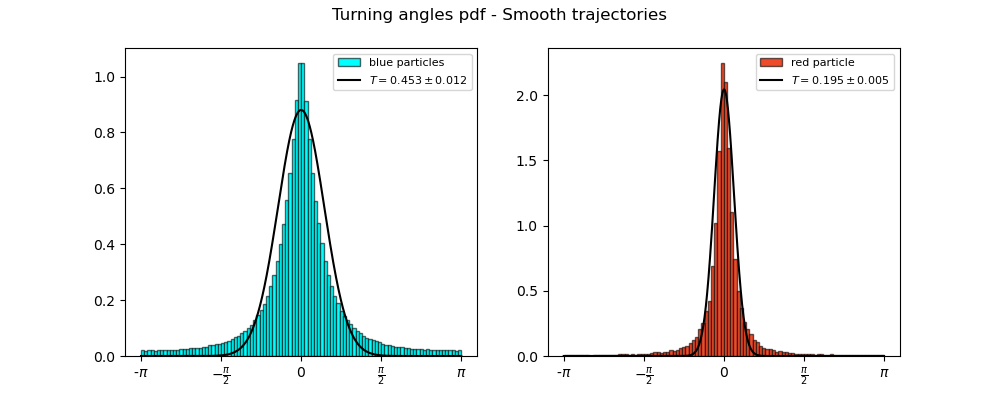

In [6]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.hist(theta_blue, bin_borders_turn, **default_kwargs_blue, label="blue particles")
ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *T_blue_rot), 'k-',
                label = f"$T = {T_blue_rot[0]:.2f} \pm {T_blue_rot_std[0]:.2f}$")
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.legend()
ax.set_ylim(0,0.5)

ax1.hist(theta_red, bin_borders_turn, **default_kwargs_red, label="red particle")
ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *T_red_rot), 'k-',
                label = f"$T = {T_red_rot[0]:.2f} \pm {T_red_rot_std[0]:.2f}$")
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax1.legend()
ax1.set_ylim(0,0.5)
plt.suptitle("Turning angles pdf - Raw trajectories")
if save_verb: plt.savefig(f"../results/turning_angles/turn_ang_raw.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.hist(theta_blue_smooth, bin_borders_turn, **default_kwargs_blue, label="blue particles")
ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn,* T_blue_rot_smooth), 'k-',
                label = f"$T = {T_blue_rot_smooth[0]:.3f} \pm {T_blue_rot_smooth_std[0]:.3f}$")
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.legend(prop={'size': 8})

ax1.hist(theta_red_smooth, bin_borders_turn, **default_kwargs_red, label="red particle")
ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *T_red_rot_smooth), 'k-',
                label = f"$T = {T_red_rot_smooth[0]:.3f} \pm {T_red_rot_smooth_std[0]:.3f}$")
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax1.legend(prop={'size': 8})

plt.suptitle("Turning angles pdf - Smooth trajectories")
if save_verb: plt.savefig(f"../results/turning_angles/turn_ang_smooth.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()

## Windowed Analysis

In [ ]:
theta_blue_wind, theta_red_wind = theta_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, rawTrajs)
theta_blue_wind_smooth, theta_red_wind_smooth = theta_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, smoothTrajs)

blue_fit_wind_turn = np.ones((nSteps, 2, 2))
red_fit_wind_turn = np.ones((nSteps, 2, 2))

for k in range(nSteps):
    blue_fit_wind_turn[k, 0], blue_fit_wind_turn[k, 1] = fit_hist(theta_blue_wind[k], bin_borders_turn, normal_distr, [1., 0.])
    red_fit_wind_turn[k, 0], red_fit_wind_turn[k, 1] = fit_hist(theta_red_wind[k], bin_borders_turn, normal_distr, [1., 0.])

blue_fit_wind_turn_smooth = np.ones((nSteps, 2, 2))
red_fit_wind_turn_smooth = np.ones((nSteps, 2, 2))

for k in range(nSteps):
    blue_fit_wind_turn_smooth[k, 0], blue_fit_wind_turn_smooth[k, 1] = fit_hist(theta_blue_wind_smooth[k], bin_borders_turn, normal_distr, [1., 0.])
    red_fit_wind_turn_smooth[k, 0], red_fit_wind_turn_smooth[k, 1] = fit_hist(theta_red_wind_smooth[k], bin_borders_turn, normal_distr, [1., 0.])

### PLOT

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        title.set_text(f"Turning angles pdf - Smooth Trajectories - window {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        n, _ = np.histogram(theta_blue_wind_smooth[frame], bin_borders_turn, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        line.set_ydata(normal_distr(x_interval_for_fit_turn, *blue_fit_wind_turn_smooth[frame, 0]))
            
        n2, _ = np.histogram(theta_red_wind_smooth[frame], bin_borders_turn, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
        
        line1.set_ydata(normal_distr(x_interval_for_fit_turn, *red_fit_wind_turn_smooth[frame, 0]))
            
        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(theta_red_wind_smooth[0], bin_borders_turn, **default_kwargs_blue, label="blue particles")
line, = ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *blue_fit_wind_turn_smooth[0, 0]), label='fit')
title = ax.set_title(f"Turning angles pdf - Smooth Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")

ax.set(ylabel = "pdf", ylim = (0, 3))
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

_, _, bar_container2 = ax1.hist(theta_red_wind_smooth[0], bin_borders_turn,  **default_kwargs_red, label="red particle")
line1, = ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *red_fit_wind_turn_smooth[0, 0]), label='fit')
ax1.set(ylabel = "pdf", ylim = (0, 3))
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
ani.save('../results/turning_angles/turn_ang_wind_smooth.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax.plot(startFrames/10, blue_fit_wind_turn[:, 0, 0], 'b', label="blue particles")
ax.fill_between(startFrames/10, blue_fit_wind_turn[:, 0, 0] - blue_fit_wind_turn[:, 1, 0],
                 blue_fit_wind_turn[:, 0, 0] + blue_fit_wind_turn[:, 1, 0], color='b', alpha=0.2)
ax.set(ylabel = "T [??]", title = "Effective Temperature - Raw Trajectories")
ax.legend()
ax.grid()

ax1.plot(startFrames/10, red_fit_wind_turn[:, 0, 0], 'r', label="red particles")
ax1.fill_between(startFrames/10, red_fit_wind_turn[:, 0, 0] - red_fit_wind_turn[:, 1, 0],
                    red_fit_wind_turn[:, 0, 0] + red_fit_wind_turn[:, 1, 0], color='r', alpha=0.2)
ax1.set(xlabel ="time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/turning_angles/effective_T_raw.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax.plot(startFrames/10, blue_fit_wind_turn_smooth[:, 0, 0], 'b', label="blue particles")
ax.fill_between(startFrames/10, blue_fit_wind_turn_smooth[:, 0, 0] - blue_fit_wind_turn_smooth[:, 1, 0],
                    blue_fit_wind_turn_smooth[:, 0, 0] + blue_fit_wind_turn_smooth[:, 1, 0], color='b', alpha=0.2)
ax.set(ylabel = "T [??]", title = "Rotational effective temperature - Smooth Trajectories")
ax.legend()
ax.grid()

ax1.plot(startFrames/10, red_fit_wind_turn_smooth[:, 0, 0], 'r', label="red particles")
ax1.fill_between(startFrames/10, red_fit_wind_turn_smooth[:, 0, 0] - red_fit_wind_turn_smooth[:, 1, 0],
                        red_fit_wind_turn_smooth[:, 0, 0] + red_fit_wind_turn_smooth[:, 1, 0], color='r', alpha=0.2)
ax1.set(xlabel = "time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/turning_angles/T_eff_smooth.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# Velocity autocorrelation
[ref](https://en.wikipedia.org/wiki/Autocovariance)

note: yupi vacf in time_avg mode performs autocovariance actually, not the autocorrelation

$$ K_{XX}(t_1, t_2) = cov \big[X_{t_1} , X_{t_2} \big] = E \big[ (X_{t_1} - \mu_{t_1}) (X_{t_2} - \mu_{t_2}) \big] = E \big[ X_{t_1}, X_{t_2} \big] - \mu_{t_1} \mu_{t_2} $$


$$ K_{XX}(\tau) = E \big[ (X_t - \mu_t) (X_{t-\tau} - \mu_{t-\tau}) \big] $$

modified yupi source code at ../pyenv/lib/python3.10/site-packages/yupi/stats/_stats.py, 
original :

    for lag_ in range(1, lag + 1):
        # Multiply components given lag
        v1, v2 = v[:-lag_], v[lag_:]
        v1v2 = (v1 - v1.mean(axis=0)) * (v2 - v2.mean(axis=0))

        # Dot product for a given lag time
        v1_dot_v2 = np.sum(v1v2, axis=1)

        # Averaging over a single realization
        current_vacf[lag_ - 1] = np.mean(v1_dot_v2)
        
modified:

    for lag_ in range(lag):
        if lag_ == 0: v1, v2 = v[:], v[:]
        else: v1, v2 = v[:-lag_], v[lag_:]
        # Multiply components given lag
        v1v2 = (v1 - v1.mean(axis=0)) * (v2 - v2.mean(axis=0))

        # Dot product for a given lag time
        v1_dot_v2 = np.sum(v1v2, axis=1)

        # Averaging over a single realization
        current_vacf[lag_] = np.mean(v1_dot_v2)

In [4]:
maxLagtime = 1000
x = np.arange(0, 100, 0.1) 

blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)

In [5]:
vacf_b, vacf_std_b = ys.vacf(blueTrajs, time_avg=True, lag = maxLagtime)
vacf_r, vacf_std_r = ys.vacf(redTraj, time_avg=True, lag = maxLagtime)

vacf_b_smooth, vacf_std_b_smooth = ys.vacf(blueTrajs_smooth, time_avg=True, lag = maxLagtime)
vacf_r_smooth, vacf_std_r_smooth = ys.vacf(redTraj_smooth, time_avg=True, lag = maxLagtime)

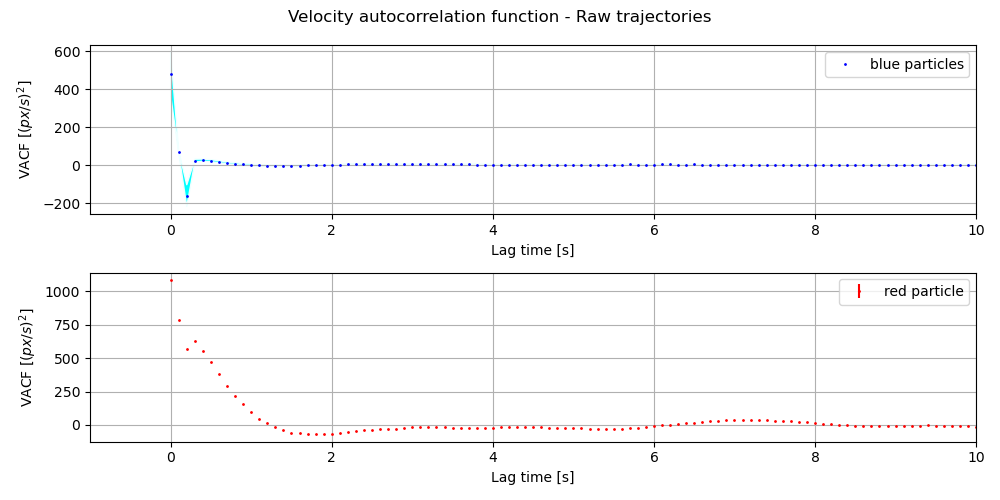

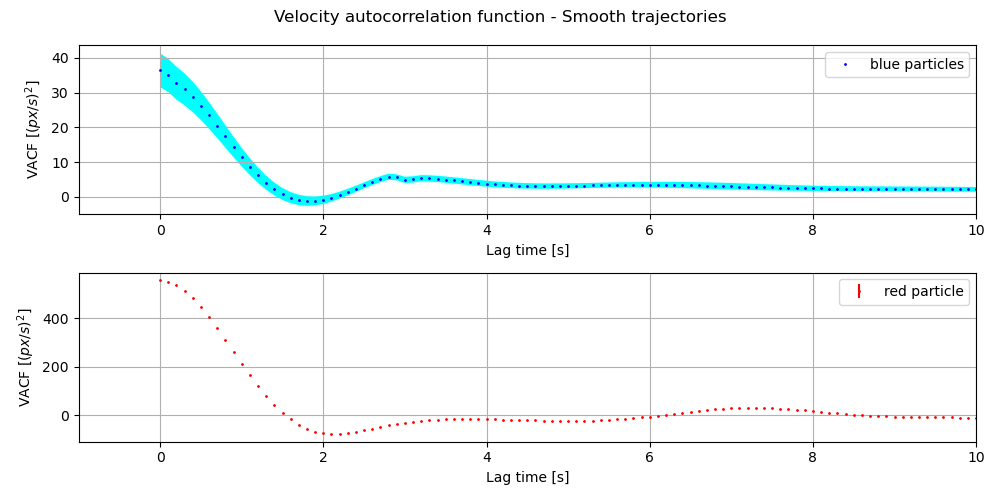

In [6]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 5))
ax.errorbar(x, vacf_b, fmt='o', markersize = 1, color = "blue", label = 'blue particles')
ax.fill_between(x, vacf_b + vacf_std_b, vacf_b - vacf_std_b, alpha=1, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.grid()
ax.legend()
ax.set(xlim = (-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax1.errorbar(x, vacf_r, yerr = vacf_std_r, fmt='o',
                markersize=1, color = "red", label = 'red particle')
ax1.set(xlim = (-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax1.grid()
ax1.legend()
plt.suptitle("Velocity autocorrelation function - Raw trajectories")
plt.tight_layout()
if 0: plt.savefig("../results/velocity_autocovariance/vacf_raw.png", dpi = 500, bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 5))
ax.errorbar(x, vacf_b_smooth, fmt='o', markersize = 1, color = "blue", label = 'blue particles')
ax.fill_between(x, vacf_b_smooth + vacf_std_b_smooth, vacf_b_smooth - vacf_std_b_smooth,
                    alpha=1, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.set(xlim=(-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax.grid()
ax.legend()
ax1.errorbar(x, vacf_r_smooth, yerr=vacf_std_r_smooth, fmt='o',
                 markersize=1, color = "red", label = 'red particle')
ax1.set(xlim=(-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax1.grid()  
ax1.legend()
plt.suptitle("Velocity autocorrelation function - Smooth trajectories")
plt.tight_layout()
if 0: plt.savefig("../results/velocity_autocovariance/vacf_smooth.png", dpi = 500, bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

## Windowed Analysis 

In [7]:
def vacf_vindowed(save_verb, trajectories, raw):        
    vacf_b_wind = []
    vacf_b_std_wind = []
    vacf_r_wind = []
    vacf_sigmas = np.zeros((nSteps, 2))

    for k in tqdm(range(nSteps)):
        trajs = trajectories.loc[trajectories.frame.between(startFrames[k], endFrames[k])]
        blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, trajs)

        temp = ys.vacf(blueTrajs, time_avg = True, lag = maxLagtime)
        vacf_b_wind.append(temp[0])
        vacf_b_std_wind.append(temp[1])

        temp  = ys.vacf(redTraj, time_avg = True, lag = maxLagtime)
        vacf_r_wind.append(temp[0])

    vacf_b_wind = pd.DataFrame(vacf_b_wind)
    vacf_b_std_wind = pd.DataFrame(vacf_b_std_wind)
    vacf_r_wind = pd.DataFrame(vacf_r_wind)

    if save_verb:
        if raw: 
            path = "../data/analysis/vacf/raw/"
        else: 
            path = "../data/analysis/vacf/smooth/"
    
        vacf_b_wind.to_csv(path + "vacf_blue_wind.csv")
        vacf_b_std_wind.to_csv(path + "vacf_blue_std_wind.csv")
        vacf_r_wind.to_csv(path + "vacf_red_wind.csv")
        
    return vacf_b_wind, vacf_b_std_wind, vacf_r_wind

In [8]:
path = "../data/analysis/vacf/raw/"
vacf_b_wind = pd.read_csv(path + "vacf_blue_wind.csv", index_col=0)
vacf_b_std_wind = pd.read_csv(path + "vacf_blue_std_wind.csv", index_col=0)
vacf_r_wind = pd.read_csv(path + "vacf_red_wind.csv", index_col=0)

path = "../data/analysis/vacf/smooth/"
vacf_b_wind_smooth = pd.read_csv(path + "vacf_blue_wind.csv", index_col=0)
vacf_b_std_wind_smooth = pd.read_csv(path + "vacf_blue_std_wind.csv", index_col=0)
vacf_r_wind_smooth = pd.read_csv(path + "vacf_red_wind.csv", index_col=0)

path = "../data/analysis/vacovf/raw/"
vacov_b_wind = pd.read_csv(path + "vacf_blue_wind.csv", index_col=0)
vacov_b_std_wind = pd.read_csv(path + "vacf_blue_std_wind.csv", index_col=0)
vacov_r_wind = pd.read_csv(path + "vacf_red_wind.csv", index_col=0)

path = "../data/analysis/vacovf/smooth/"
vacov_b_wind_smooth = pd.read_csv(path + "vacf_blue_wind.csv", index_col=0)
vacov_b_std_wind_smooth = pd.read_csv(path + "vacf_blue_std_wind.csv", index_col=0)
vacov_r_wind_smooth = pd.read_csv(path + "vacf_red_wind.csv", index_col=0)

In [10]:
vacf_b_wind - vacov_b_wind

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.402684,0.403658,0.404632,0.404368,0.404786,0.404734,0.404633,0.406420,0.405673,0.404971,...,0.295356,0.293824,0.290446,0.289819,0.289981,0.291265,0.291409,0.292692,0.293602,0.292566
1,0.367488,0.368130,0.368783,0.369587,0.369503,0.370233,0.370657,0.370287,0.370631,0.371351,...,0.260269,0.257071,0.255449,0.256617,0.254735,0.253596,0.251216,0.248322,0.248708,0.248539
2,0.332861,0.331550,0.330241,0.330590,0.331494,0.331956,0.331681,0.330375,0.330200,0.331082,...,0.222303,0.222340,0.220254,0.218951,0.220301,0.219689,0.216862,0.216309,0.215701,0.216205
3,0.313261,0.314117,0.314987,0.315001,0.314651,0.313896,0.313791,0.313765,0.313494,0.313168,...,0.186293,0.186454,0.184648,0.184513,0.184118,0.182730,0.184389,0.183636,0.178814,0.177744
4,0.312861,0.312715,0.312586,0.311914,0.312009,0.313081,0.313933,0.312009,0.311333,0.312337,...,0.136733,0.137483,0.137711,0.137150,0.136486,0.137421,0.139002,0.139417,0.138977,0.140714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.653816,0.652797,0.651776,0.651777,0.652832,0.653400,0.653227,0.653639,0.654299,0.654431,...,0.487333,0.486395,0.487573,0.487078,0.486095,0.487456,0.485838,0.483079,0.482080,0.483401
284,0.676018,0.677341,0.678668,0.678837,0.678658,0.678866,0.679660,0.680261,0.679651,0.679348,...,0.453849,0.456084,0.457308,0.456361,0.454806,0.452208,0.452310,0.452838,0.453022,0.453060
285,0.701375,0.699721,0.698069,0.698780,0.700723,0.700813,0.701010,0.701405,0.702158,0.702322,...,0.478869,0.478902,0.478210,0.476166,0.474751,0.474445,0.473214,0.472853,0.472101,0.470221
286,0.683557,0.683427,0.683297,0.682298,0.683651,0.684866,0.684806,0.684866,0.685961,0.686489,...,0.469280,0.467509,0.466409,0.465974,0.464749,0.463518,0.463910,0.462278,0.461354,0.461805


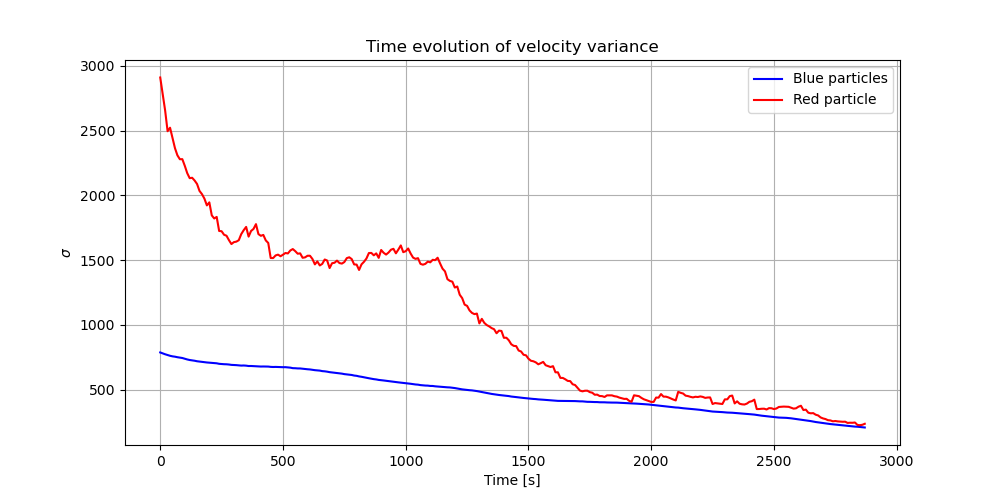

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(startFrames/10, vacf_b_wind["0"], 'b', label = "Blue particles")
ax.plot(startFrames/10, vacf_r_wind["0"], 'r', label = "Red particle")
ax.set(title = "Time evolution of velocity variance", ylabel = "$\sigma$", xlabel = "Time [s]")
ax.grid()
ax.legend()
plt.show()

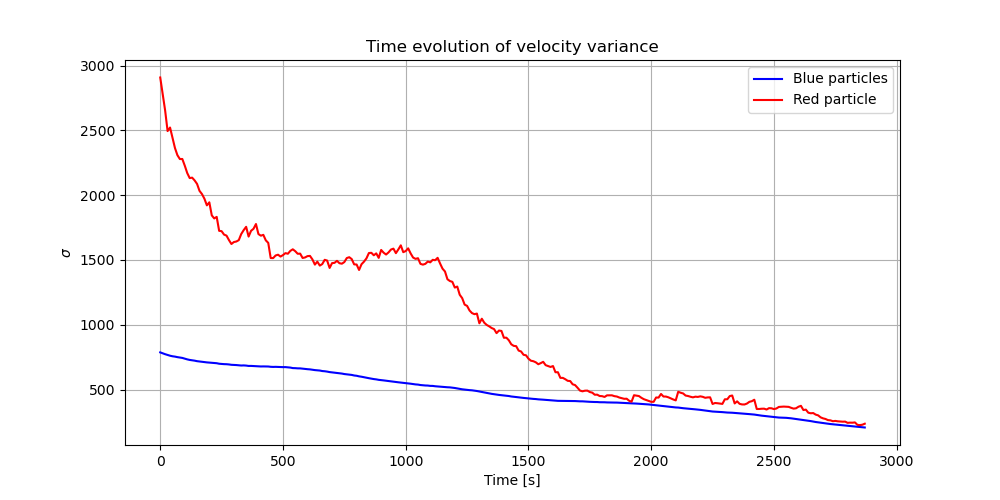

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(startFrames/10, vacov_b_wind["0"], 'b', label = "Blue particles")
ax.plot(startFrames/10, vacov_r_wind["0"], 'r', label = "Red particle")
ax.set(title = "Time evolution of velocity variance", ylabel = "$\sigma$", xlabel = "Time [s]")
ax.grid()
ax.legend()
plt.show()

In [10]:
fig = plt.figure(figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    line.set_ydata(vacf_b_wind.iloc[step])
    title.set_text(f"Velocity autocorrelation - Raw Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    line1.set_ydata(vacf_r_wind.iloc[step])
    return line, line1,

ax = fig.add_subplot(211)
title = ax.set_title(f"Velocity autocorrelation - Raw Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
line, = ax.plot(np.arange(0.1, 100.1, 0.1), vacf_b_wind.iloc[0], 'b-', label = 'Blue particles')
ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.2))
ax.grid()
ax.legend()

ax1 = fig.add_subplot(212)

line1, = ax1.plot(np.arange(0.1, 100.1, 0.1), vacf_r_wind.iloc[0], 'r-', label = 'Red particle')
ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.2))
ax1.grid()
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/velocity_autocovariance/vacf_wind_raw.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

09:41:47 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
09:41:47 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/velocity_autocovariance/vacf_wind_raw.mp4


## Windowed Analysis - Smooth Trajectory

In [ ]:
if 1:
    vacf_b_wind_smooth = []
    vacf_b_std_wind_smooth = []
    vacf_r_wind_smooth = []
    vacf_sigmas_smooth = np.zeros((nSteps, 2))

    for k in tqdm(range(nSteps)):
        trajs = smoothTrajs.loc[smoothTrajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, trajs)

        temp = ys.vacf(blueTrajs, time_avg=True, lag=maxLagtime)
        vacf_b_wind_smooth.append(temp[0])
        vacf_b_std_wind_smooth.append(temp[1])
        vacf_sigmas_smooth[k, 0] = np.mean(temp[2])

        temp = ys.vacf(redTraj, time_avg=True, lag=maxLagtime)
        vacf_r_wind_smooth.append(temp[0])
        vacf_sigmas_smooth[k, 1] = np.mean(temp[2])
    
    vacf_b_wind_smooth = pd.DataFrame(vacf_b_wind_smooth)
    vacf_b_std_wind_smooth = pd.DataFrame(vacf_b_std_wind_smooth)
    vacf_r_wind_smooth = pd.DataFrame(vacf_r_wind_smooth)
    vacf_sigmas_smooth = pd.DataFrame(vacf_sigmas)

    vacf_b_wind_smooth.to_csv("../data/analysis/vacf/vacf_blue_wind_smooth.csv")
    vacf_b_std_wind_smooth.to_csv("../data/analysis/vacf/vacf_blue_std_wind_smooth.csv")
    vacf_r_wind_smooth.to_csv("../data/analysis/vacf/vacf_red_wind_smooth.csv")
    vacf_sigmas_smooth.to_csv("../data/analysis/vacf/vacf_sigmas_smooth.csv")
else:
    vacf_b_wind_smooth = pd.read_csv("../data/analysis/vacf/vacf_blue_wind_smooth.csv", index_col=0)
    vacf_b_std_wind_smooth = pd.read_csv("../data/analysis/vacf/vacf_blue_std_wind_smooth.csv", index_col=0)
    vacf_r_wind_smooth = pd.read_csv("../data/analysis/vacf/vacf_red_wind_smooth.csv", index_col=0)
    vacf_sigmas_smooth = pd.read_csv("../data/analysis/vacf/vacf_sigmas_smooth.csv", index_col=0)

100%|██████████| 288/288 [29:39<00:00,  6.18s/it]


In [12]:
fig = plt.figure(figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    line.set_ydata(vacf_b_wind_smooth.iloc[step])
    title.set_text(f"Velocity autocorrelation - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    line1.set_ydata(vacf_r_wind_smooth.iloc[step])
    return line, line1,

ax = fig.add_subplot(211)
title = ax.set_title(f"Velocity autocorrelation - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
line, = ax.plot(np.arange(0.1, 100.1, 0.1), vacf_b_wind_smooth.iloc[0], 'b-', label = 'Blue particles')
ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20))
ax.grid()
ax.legend()

ax1 = fig.add_subplot(212)
line1, = ax1.plot(np.arange(0.1, 100.1, 0.1), vacf_r_wind_smooth.iloc[0], 'r-', label = 'Red particle')
ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20))
ax1.grid()
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/velocity_autocovariance/vacf_wind_smooth.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

09:42:14 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
09:42:14 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/velocity_autocovariance/vacf_wind_smooth.mp4


# Radial Distribution Function


The radial distribution function in 2D is:
$$ g_2(r) = \frac{n(r)}{\pi [(r+\delta r)^2 - r^2 ] \rho} $$

where the density is $\rho = N/V $ and the number density $n(r)$ is computed (using a KDTree data structure) by taking the number of elements closer than $r + \delta r$ minus the number of elements closer than $r$

In 3D (i think):
$$ S_r = 4 \pi r^2 g_2(r) $$

in 2D ???

## regular

In [5]:
@joblib.delayed
def computeRadialDistributionFunction(frame, COORDS, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)

    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        a = kd.query_ball_point(coords, r + 20)
        b = kd.query_ball_point(coords, r)
        
        n1 = 0
        for j in a:
            n1 += len(j) - 1

        n2 = 0
        for j in b:
            n2 += len(j) - 1
        
        avg_n[i] = n1/len(a) - n2/len(b)

    g2 = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return g2

In [6]:
dr = 5
rDisk = 822/2
rList = np.arange(0, 2*rDisk, 1)
rho = nDrops/(np.pi*rDisk**2) # nDrops -1 !

COORDS = np.array(rawTrajs.loc[:,["x","y"]])

In [7]:
parallel = joblib.Parallel(n_jobs = -2)
frames = 200
trial = parallel(
    computeRadialDistributionFunction(frame, COORDS, rList, dr, rho)
    for frame in tqdm( range(frames) )
)
trial = np.array(trial)

100%|██████████| 200/200 [00:27<00:00,  7.16it/s]


In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, trial[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(trial[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(trial[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, frames), interval=20, blit=False)
plt.show()

### RDF analysis with full dataset already computed

In [ ]:
g2 = np.array(pd.read_csv("/Users/matteoscandola/thesis/data/g2.csv"))

In [ ]:
g2.shape

In [ ]:
g_plot = g2[::30, :].T

timearr = np.linspace(0, 30000, 10)/10
timearr = timearr.astype(int)


fig, ax = plt.subplots(1, 1, figsize=(8,6))
img = ax.imshow(np.log(1 + g_plot))
ax.set_xticks(np.linspace(0, g_plot.shape[1], 10))
ax.set_yticks(np.linspace(0, g_plot.shape[0], 10))
ax.set_xticklabels(timearr)
ax.set_yticklabels(np.linspace(0, 2*rDisk, 10).astype(int))
fig.colorbar(img)
plt.xlabel("Time [s]")
plt.ylabel("r [px]")
plt.title("$Log(1 + g_2)$ heatmap ")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(rList, np.mean(g2, axis = 0), yerr = np.std(g2, axis = 0), marker = ".")
#ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

#### Moving averages

In [ ]:
# axis = 0 --> Time moving average
# axis = 1 --> Radius moving average
def running_mean_uniform_filter1d(x, N, AX):
    return uniform_filter1d(x, N, mode='constant', axis = AX, origin=-(N//2))#[:-(N-1)]

##### r-averaged

In [ ]:
g2_r_avg = running_mean_uniform_filter1d(g2, 5, 1)

In [ ]:
fig, ax = plt.subplots()
#ax.plot(rList, g2_r_avg[0])
ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, g2_r_avg[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(g2_r_avg[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(g2_r_avg[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, 30000, 5), interval=2, blit=False)
plt.show()

In [ ]:
g2_r_avg.shape
g2.shape

In [ ]:
nFrames = 30000
rmax = np.zeros(nFrames)
rmax_r_avg = np.zeros(nFrames)

rMin = 200

for i in range(nFrames):
    rmax[i] = rList[np.where(g2[i]==0)[0][np.where(g2[i]==0)[0]>rMin][0]]
    rmax_r_avg[i] = rList[np.where(g2_r_avg[i]==0)[0][np.where(g2_r_avg[i]==0)[0]>rMin][0]]
    
framesList = np.arange(0, nFrames, 1)

fig, (ax, ax1) = plt.subplots(1, 2)

ax.plot(framesList, rmax)
ax1.plot(framesList, rmax_r_avg)

ax.set_title("$R_{max}$")
ax1.set_title("Moving average $R_{max}$")
plt.show()

##### time averaged 

In [ ]:
g2_time_avg = running_mean_uniform_filter1d(g2, 50, 0)

In [ ]:
fig, ax = plt.subplots()
ax.plot(rList, g2_time_avg[0])
ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, g2_time_avg[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(g2_time_avg[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(g2_r_avg[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(25000, nFrames), interval=2, blit=False)
#ani.save(f'/Users/matteoscandola/thesisData/rolled2.mp4', writer=writervideo)
#plt.show()

In [ ]:
rmax = np.zeros(nFrames)
rmax_roll = np.zeros(nFrames)

rMin = 450

for i in range(nFrames):
    rmax[i] = rList[np.where(g_2[i]==0)[0][np.where(g_2[i]==0)[0]>rMin][0]]
    rmax_roll[i] = rList[np.where(g_2_roll[i]==0)[0][np.where(g_2_roll[i]==0)[0]>rMin][0]]
    
framesList = np.arange(0, nFrames, 1)

fig, (ax, ax1) = plt.subplots(1, 2)

ax.plot(framesList, rmax)
ax1.plot(framesList, rmax_roll)

ax.set_title("$R_{max}$")
ax1.set_title("Moving average $R_{max}$")
plt.show()

## from centre

In [9]:
dr = 20
rDisk = 822/2
rList = np.arange(0, rDisk, 1)
rho = nDrops/(np.pi*rDisk**2) # nDrops -1 !

COORDS = np.array(rawTrajs.loc[:,["x","y"]])

#centre of the image --> to refine
r_c = [470, 490]

In [6]:
@joblib.delayed
def rdf_from_centre(frame, COORDS, r_c, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)

    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        # find all the points within r+dr
        a = kd.query_ball_point(r_c, r + dr)
        n1 = len(a) 
        # find all the points within r+dr
        b = kd.query_ball_point(r_c, r)
        n2 = len(b)
        
        avg_n[i] = n1 - n2

    g2 = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return g2

In [ ]:
parallel = joblib.Parallel(n_jobs = -2)
frames = nFrames
trial = parallel(
    rdf_from_centre(frame, COORDS, r_c, rList, dr, rho)
    for frame in tqdm( range(frames) )
)
trial = np.array(trial)

In [9]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, trial[0])
title = ax.set_title('Test, time=0')
ax.set_ylim(-1, 10)

def animate(frame):
    line.set_ydata(trial[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, frames), interval=5, blit=False)
ani.save('../results/video/rdf_from_centre2.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
plt.close()

12:53:26 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
12:53:26 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 60 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/video/rdf_from_centre2.mp4


In [7]:
g2_centre = np.array(pd.read_parquet("../data/analysis/ref_centre.parquet"))

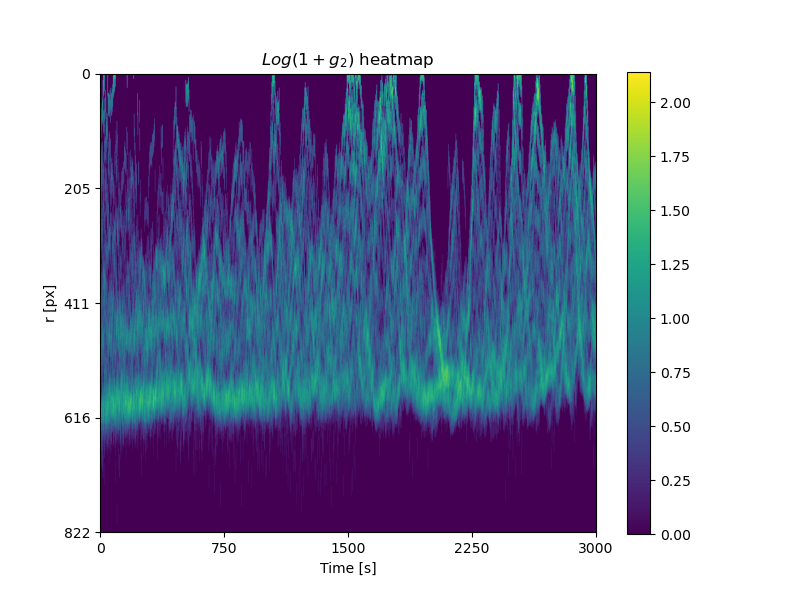

In [10]:
g_plot = g2_centre[::30, :].T

timearr = np.linspace(0, 30000, 5)/10
timearr = timearr.astype(int)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
img = ax.imshow(np.log(1 + g_plot))
ax.set_xticks(np.linspace(0, g_plot.shape[1], 5))
ax.set_yticks(np.linspace(0, g_plot.shape[0], 5))
ax.set_xticklabels(timearr)
ax.set_yticklabels(np.linspace(0, 2*rDisk, 5).astype(int))
ax.set_aspect(.6)
fig.colorbar(img)
plt.xlabel("Time [s]")
plt.ylabel("r [px]")
plt.title("$Log(1 + g_2)$ heatmap ")
plt.show()

In [ ]:
frame = 0
coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
kd = KDTree(coords)

In [ ]:
coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
kd = KDTree(coords)

r = 100
a = kd.query_ball_point(centre, r + 20)
b = kd.query_ball_point(centre, r)
print(a)
print('\n')
print(b)
n1 = len(a)
n2 = len(b)

resu = n1-n2
print(resu)

In [ ]:
frame = 0
covMatrix = np.cov(COORDS[frame*nDrops:(frame+1)*nDrops,:])
trace_of_covMatrix = np.trace(covMatrix)
eigenvalues, _ = np.linalg.eigh(covMatrix)
#eigenvalues = np.sort(eigenvalues)[::-1]
#diagCovMatrix = np.diag(eigenvalues)
info = np.zeros(len(eigenvalues))
for i in range(len(eigenvalues)):
    info[i] = np.sum(np.sum(eigenvalues[:i]))
info /= trace_of_covMatrix

# ROBA NUOVA

In [10]:
COORDS = np.array(rawTrajs.loc[:,["x","y"]])

for frame in range(1):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)
    _, n = kd.query(coords, 3)
    n = np.array(n)[:, 1:]
    print(n)
    disp = np.zeros((nDrops, 2, 2))
    #for i in range(nDrops):
    #    disp[i] = coords[n] - coords[i] 


[[30 28]
 [ 2  6]
 [ 1  6]
 [ 9 27]
 [13 39]
 [ 3  9]
 [ 1  2]
 [25  8]
 [25 23]
 [ 3  5]
 [16  6]
 [ 5  3]
 [15  9]
 [17  4]
 [23 21]
 [12 20]
 [20 21]
 [13 19]
 [19 22]
 [18 22]
 [16 21]
 [14 16]
 [18 19]
 [14  8]
 [26  7]
 [ 7  8]
 [24 40]
 [ 3 47]
 [29 33]
 [28 31]
 [38  0]
 [32 29]
 [36 31]
 [28 34]
 [33 42]
 [31 44]
 [32 43]
 [38 48]
 [37 30]
 [41 46]
 [42 37]
 [39 48]
 [34 45]
 [49 44]
 [43 45]
 [44 42]
 [39 41]
 [49 27]
 [41 37]
 [43 47]]
